# Polynomial Regression from Scratch

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

class PolynomialRegression:
    def __init__(self, degree, method='gradient_descent', lambda_=0.0, alpha=0.01, n_iterations=1000, regularization=None):
        self.degree = degree
        self.coefficients = None
        self.method = method
        self.lambda_ = lambda_
        self.alpha = alpha
        self.n_iterations = n_iterations
        self.regularization = regularization

    def fit(self, X, y):
        if self.method == 'gradient_descent':
            self._fit_gradient_descent(X, y)
        elif self.method == 'normal_equation':
            self._fit_normal_equation(X, y)

    def predict(self, X):
        if self.coefficients is None:
            raise ValueError("Model coefficients have not been calculated. Please fit the model first.")
        X_poly = self._polynomial_features(X, self.degree)
        return X_poly.dot(self.coefficients)

    def _polynomial_features(self, X, degree):
        n_samples, n_features = X.shape
        X_poly = np.ones((n_samples, 1))

        for d in range(1, degree + 1):
            X_poly = np.hstack((X_poly, X ** d))

        return X_poly
    
    def _fit_gradient_descent(self, X, y):
        X_poly = self._polynomial_features(X, self.degree)
        n_samples, n_features = X_poly.shape
        self.coefficients = np.random.randn(n_features) * 0.01  # Initialize coefficients with small random values
        
        for _ in range(self.n_iterations):
            error = X_poly.dot(self.coefficients) - y
            gradient = X_poly.T.dot(error) / n_samples

            if self.regularization == 'l2':
                gradient += self.lambda_ * self.coefficients
            elif self.regularization == 'l1':
                gradient += self.lambda_ * np.sign(self.coefficients)

            self.coefficients -= self.alpha * gradient

    def _fit_normal_equation(self, X, y):
        X_poly = self._polynomial_features(X, self.degree)
        regularization_matrix = self.lambda_ * np.eye(X_poly.shape[1])
        regularization_matrix[0, 0] = 0  # Don't regularize the bias term
        self.coefficients = np.linalg.inv(X_poly.T.dot(X_poly) + regularization_matrix).dot(X_poly.T).dot(y)
        
        

# Verileri yükleme ve hazırlama
data = pd.read_csv('processed_dataset.csv')


# Kategorik değişkeni sayısal değere dönüştürme
le = LabelEncoder()
data['city'] = le.fit_transform(data['city'])

scaler = StandardScaler()
numeric_features = ['population', 'time_since_event', 'population_density']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Drop non-feature columns from the DataFrame
X = data.drop(columns=['total_cases','carried_over_from','opened_inside_year','finished','carried_over_to'])

# Separate the target variable
y = data['opened_inside_year']

# Split data into training and testing sets
# First 81 row is the year 2021
X_train, X_test, y_train, y_test = X.iloc[81:], X.iloc[:81], y.iloc[81:], y.iloc[:81]

In [2]:
# Define hyperparameters for grid search
degrees = [2,3,4,5,6,7,8,9]  # Set to 2 as per your requirement
lambda_values = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]

best_accuracy = 0
best_params = {}

# Perform grid search
for degree in degrees:
    for lambda_ in lambda_values:
        # Initialize and fit the model
        model = PolynomialRegression(degree=degree, lambda_=lambda_,method='normal_equation')
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate absolute percentage error for each prediction
        absolute_percentage_errors = np.abs((y_test - y_pred) / y_test)

        # Calculate mean absolute percentage error
        mape = np.mean(absolute_percentage_errors)

        # Convert MAPE to accuracy (accuracy = 1 - MAPE)
        accuracy = 1 - mape

        # Check if current parameters give better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'degree': degree, 'lambda_': lambda_}

In [3]:
print(best_accuracy)
print(best_params)

0.8101649723937394
{'degree': 3, 'lambda_': 0.1}


In [4]:
degree = 3
lambda_ = 0.1
first_model = PolynomialRegression(degree, method='normal_equation', lambda_=lambda_)
first_model.fit(X_train, y_train)

# Tahminler
y_pred = first_model.predict(X_test)


# Print predicted and real y-values for the first 10 rows
for i in range(10):
    print("Predicted:", y_pred[i], "\tReal:", y_test.iloc[i])

# Calculate absolute percentage error for each prediction
absolute_percentage_errors = np.abs((y_test - y_pred) / y_test)

# Calculate mean absolute percentage error
mape = np.mean(absolute_percentage_errors)

# Convert MAPE to accuracy (accuracy = 1 - MAPE)
accuracy = 1 - mape

# Convert accuracy to percentage
percentage_accuracy = accuracy * 100

print("Average Percentage Accuracy:", percentage_accuracy)

Predicted: 725078.6576883427 	Real: 841644
Predicted: 49677.97096453064 	Real: 67719
Predicted: 18599.879599578686 	Real: 25475
Predicted: 17340.123567660798 	Real: 18984
Predicted: 57598.299684141224 	Real: 73542
Predicted: 21003.285643462208 	Real: 33447
Predicted: 226093.1320385491 	Real: 305541
Predicted: 52471.2278310627 	Real: 87538
Predicted: 46765.70611628214 	Real: 59477
Predicted: 45434.7756868412 	Real: 83130
Average Percentage Accuracy: 81.01649723937395


In [5]:
# Verileri yükleme ve hazırlama
second_data = pd.read_csv('processed_dataset.csv')


# Kategorik değişkeni sayısal değere dönüştürme
le = LabelEncoder()
second_data['city'] = le.fit_transform(data['city'])

scaler = StandardScaler()
numeric_features = ['population', 'time_since_event', 'population_density','opened_inside_year']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Drop non-feature columns from the DataFrame
X = data.drop(columns=['total_cases','carried_over_from','finished','carried_over_to'])

# Separate the target variable
y = data['finished']

# Split data into training and testing sets
# First 81 row is the year 2021
X_train, X_test, y_train, y_test = X.iloc[81:], X.iloc[:81], y.iloc[81:], y.iloc[:81]

print(X_test)

X_test['opened_inside_year'] = scaler.fit_transform(y_pred.reshape(-1, 1))

    city  population  opened_inside_year  time_since_event  population_density
0     77    8.258141            9.012503         -1.603567            9.099474
1     65    0.083572            0.244045         -1.603567            0.196826
2     24   -0.325060           -0.234574         -1.603567           -0.190516
3     46   -0.350160           -0.308116         -1.603567           -0.224477
4     11    0.161181            0.310018         -1.603567           -0.125699
..   ...         ...                 ...               ...                 ...
76    22    0.483099            0.489812         -1.603567           -0.010111
77    51   -0.060191           -0.120867         -1.603567           -0.081041
78    13   -0.197216           -0.236738         -1.603567            0.062524
79    80   -0.243567           -0.257687         -1.603567           -0.152666
80    62   -0.368844           -0.347329         -1.603567           -0.218611

[81 rows x 5 columns]


C:\Users\berat\AppData\Local\Temp\ipykernel_976\3169786450.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['opened_inside_year'] = scaler.fit_transform(y_pred.reshape(-1, 1))


In [6]:
print(X_test)

    city  population  opened_inside_year  time_since_event  population_density
0     77    8.258141            7.593944         -1.603567            9.099474
1     65    0.083572            0.009717         -1.603567            0.196826
2     24   -0.325060           -0.339266         -1.603567           -0.190516
3     46   -0.350160           -0.353412         -1.603567           -0.224477
4     11    0.161181            0.098656         -1.603567           -0.125699
..   ...         ...                 ...               ...                 ...
76    22    0.483099            0.424145         -1.603567           -0.010111
77    51   -0.060191           -0.107708         -1.603567           -0.081041
78    13   -0.197216           -0.223437         -1.603567            0.062524
79    80   -0.243567           -0.339257         -1.603567           -0.152666
80    62   -0.368844           -0.376963         -1.603567           -0.218611

[81 rows x 5 columns]


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

degree = 3
lambda_ = 0.1
second_model = PolynomialRegression(degree, method='normal_equation', lambda_=lambda_)
second_model.fit(X_train, y_train)

# Tahminler
y_pred = second_model.predict(X_test)


# Print predicted and real y-values for the first 10 rows
for i in range(10):
    print("Predicted:", y_pred[i], "\tReal:", y_test.iloc[i])

# Calculate absolute percentage error for each prediction
absolute_percentage_errors = np.abs((y_test - y_pred) / y_test)

# Calculate mean absolute percentage error
mape = np.mean(absolute_percentage_errors)

# Convert MAPE to accuracy (accuracy = 1 - MAPE)
accuracy = 1 - mape

# Convert accuracy to percentage
percentage_accuracy = accuracy * 100

print("Average Percentage Accuracy:", percentage_accuracy)
print(r2_score(y_test, y_pred))

Predicted: 647834.0931827136 	Real: 836525
Predicted: 46417.815006054574 	Real: 62603
Predicted: 17952.50753894025 	Real: 27064
Predicted: 17560.12610222983 	Real: 18939
Predicted: 53592.094785021836 	Real: 74267
Predicted: 21587.016974707763 	Real: 33954
Predicted: 214822.7838498897 	Real: 289353
Predicted: 48357.72035182153 	Real: 85850
Predicted: 43219.70965988445 	Real: 61448
Predicted: 42909.37031774336 	Real: 78778
Average Percentage Accuracy: 79.19843748597623
0.925457023274464


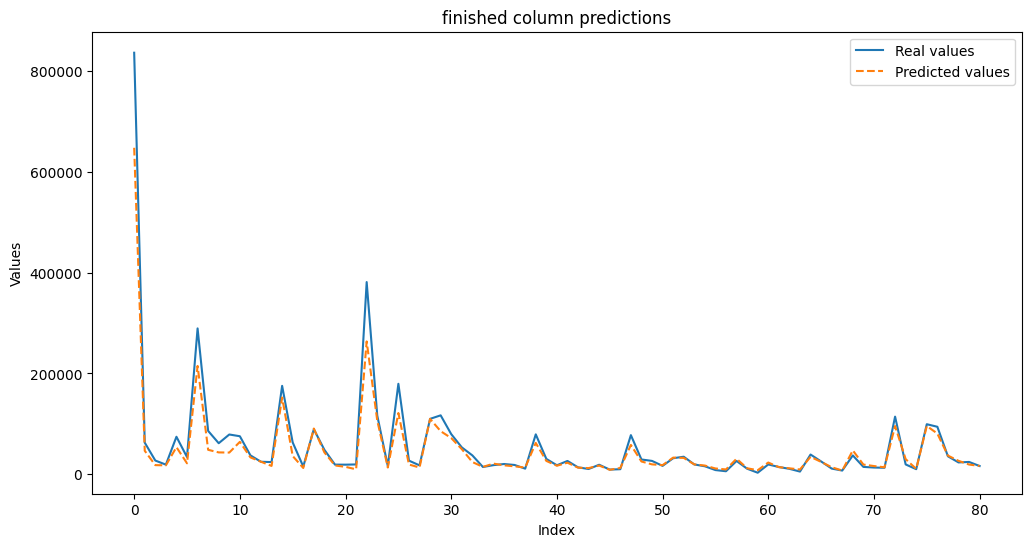

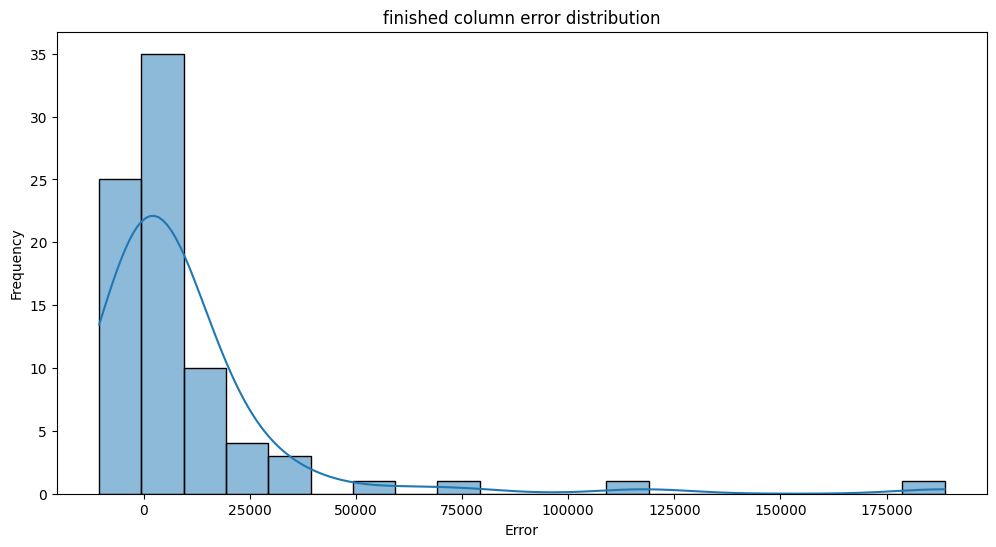

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Gerçek ve tahmin edilen değerlerin çizimi
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Real values')
    plt.plot(y_pred, label='Predicted values', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Hata dağılımının çizimi
def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    
    
plot_predictions(y_test,y_pred,"finished column predictions")
plot_error_distribution(y_test,y_pred,"finished column error distribution")
